In [1]:
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, HoverTool, FactorRange, NumeralTickFormatter, Select, Div, LegendItem, DatetimeTickFormatter
from bokeh.layouts import column, row
from bokeh.models.annotations import Label
from bokeh.palettes import d3, Turbo256, tol
import ipywidgets as widgets
from IPython.display import display
import jupyter_bokeh as jbk

import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

In [2]:
# activate Bokeh output in Jupyter notebook
output_notebook()

Loading BokehJS ...

In [3]:
# Read all pickle files containing all the cleaned data and useful dataframes

df_asset = pd.read_pickle("../data/asset_subset.pkl")
df_inflation = pd.read_pickle("../data/inflation_subset.pkl")
pct_asset = pd.read_pickle("../data/pct_asset.pkl")
pct_inflation = pd.read_pickle("../data/pct_inflation.pkl")
data = pd.read_pickle("../data/data_only.pkl")

## **First Order Value Trend Overtime** 
- In the next following figure
- you can have an overview on the trend of each asset and inflation indicators in the first order over time
- for scaling purpose, the figure consists of four parts with assets on the first row and indicators on the second row

In [4]:
# Full palette
full_palette = list(d3['Category20'][16])

# Divide the palette into four segments
palette_segment_size = len(full_palette) // 4
palettes = [full_palette[i:i + palette_segment_size] for i in range(0, len(full_palette), palette_segment_size)]

# Assign each segment to a figure
p1_colors = palettes[0]
p2_colors = palettes[1]
p3_colors = palettes[2]
p4_colors = palettes[3]

# Initialize four figures and connect the x axises
p1 = figure(width=500, height=400, x_axis_type="datetime", title="Asset Prices 1")
p2 = figure(width=500, height=400, x_axis_type="datetime", title="Asset Prices 2", x_range=p1.x_range)
p3 = figure(width=500, height=400, x_axis_type="datetime", title="Inflation", x_range=p1.x_range)
p4 = figure(width=500, height=400, x_axis_type="datetime", title="CPI", x_range=p1.x_range)

# Add lines for assets
for i, col in enumerate(['House_price', 'Shanghai_stock_index', 'Gold_price', 'Fixed_deposit_rate']):
    source = ColumnDataSource(data={
        'x': df_asset['Time'],
        'y': df_asset[col],
        'label': [col] * len(df_asset)  # Repeat the column name to match the length of the data
    })
    p1.line('x', 'y', source=source, color=p1_colors[i % len(p1_colors)], legend_label=col)

for i, col in enumerate(['government_bond_yield_sixm', 'government_bond_yield_fivey', 'government_bond_yield_teny']):
    source = ColumnDataSource(data={
        'x': df_asset['Time'],
        'y': df_asset[col],
        'label': [col] * len(df_asset)  # Repeat the column name to match the length of the data
    })
    p2.line('x', 'y', source=source, color=p2_colors[i % len(p2_colors)], legend_label=col)

# Add lines for inflation indicators
for i, col in enumerate(['core_inflation', 'headline_inflation']):
    source = ColumnDataSource(data={
        'x': df_inflation['Time'],
        'y': df_inflation[col],
        'label': [col] * len(df_inflation)  # Repeat the column name to match the length of the data
    })
    p3.line('x', 'y', source=source, color=p3_colors[i + 1 % len(p3_colors)], legend_label=col)

for i, col in enumerate(['core_CPI', 'headline_CPI']):
    source = ColumnDataSource(data={
        'x': df_inflation['Time'],
        'y': df_inflation[col],
        'label': [col] * len(df_inflation)  # Repeat the column name to match the length of the data
    })
    p4.line('x', 'y', source=source, color=p4_colors[i % len(p4_colors)], legend_label=col)

# Add HoverTool
hover = HoverTool(tooltips=[("Label", "@label"), ("Time", "@x{%F}"), ("Value", "@y")], formatters={'@x': 'datetime'})
p1.add_tools(hover)
p2.add_tools(hover)
p3.add_tools(hover)
p4.add_tools(hover)

# Adjust the legends
p1.legend.location = "top_right"
p3.legend.location = "top_center"
p4.legend.location = "top_left"
p1.legend.background_fill_alpha = 0
p2.legend.background_fill_alpha = 0
p3.legend.background_fill_alpha = 0
p4.legend.background_fill_alpha = 0
p1.legend.label_text_font_size = "8pt"
p2.legend.label_text_font_size = "8pt"
p3.legend.label_text_font_size = "8pt"
p4.legend.label_text_font_size = "8pt"

# Give a markup instruction
instruction = Div(text="""
    <p style='background-color: #ADD8E6; padding: 10px; font-size: 16px;'><b>Instructions:</b> Hover over the plot to see data values. Use the toolbar to pan, zoom, and reset.<br>The four charts are connected, zoom in on one, the others will adjust accordingly.</p>
""", width=800, align="center", margin=10, )

# Layout
p = column(instruction, row(p1, p2), row(p3, p4))

show(p)

## **Second Order Percentage Change in All Assets And Inflation Indicators**
- With "All asset"/"All inflation" tag, you can browse through all percentage change in bar chart, with nested coordinates, you can compare all the assets/inflation indicators within a specific quarter in a year
- With "All asset in lines"/"All inflation in lines" tag, the line charts are shown comparatively, you can get the trend of percentage change over time
- With specific tags in assets/inflation indicators, a histogram is shown

In [5]:
years = sorted(df_asset['Year'].unique().tolist())
quarters = sorted(df_asset['Quarter'].unique().tolist())

In [6]:
select_pct_tag = 'All asset'
select_inflation_tag = 'All inflation'
asset_pct = pct_asset.drop(columns=['Time','Year','Quarter']).columns.tolist()
inflation_pct = pct_inflation.drop(columns=['Time','Year','Quarter']).columns.tolist()

In [7]:
# Function to select N equally spaced colors from a palette
def select_n_colors(palette, n):
    indices = np.linspace(0, len(palette) - 1, n, dtype=int)
    return [palette[i] for i in indices]

# Select 10 equally spaced colors from the Turbo palette
#palette = select_n_colors(Turbo256, 10)

palette = list(tol['TolRainbow'][14])
all_labels = sorted(set(inflation_pct) | set(asset_pct))
color_mapping = {label: palette[i % len(palette)] for i, label in enumerate(all_labels)}

In [8]:
def data_prepare_asset(select_tag):
    asset = []
    if select_tag == 'All asset':
        asset = asset_pct
    else:
        asset = [select_tag]
    data = pct_asset.pivot_table(
        values=asset,
        index=['Year', 'Quarter']
    )
    
    x_range = FactorRange(factors=[(str(year), quarter, item) for year in years for quarter in quarters for item in asset])
    
    x_labels = [(str(year), quarter, item) for year in years for quarter in quarters for item in asset]
     
    return data, x_labels, x_range

In [9]:
def data_prepare_inflation(select_tag):
    asset = []
    if select_tag == 'All inflation':
        asset = inflation_pct
    else:
        asset = [select_tag]
    data = pct_inflation.pivot_table(
        values=asset,
        index=['Year', 'Quarter']
    )
    
    x_range = FactorRange(factors=[(str(year), quarter, item) for year in years for quarter in quarters for item in asset])
    
    x_labels = [(str(year), quarter, item) for year in years for quarter in quarters for item in asset]
     
    return data, x_labels, x_range

In [10]:
def create_source(data, x_labels):
    
    y = data.values.flatten().tolist()
    
    labels = data.columns.tolist() * len(data)
    
    colors = [color_mapping[label] for label in labels]
    
    source = dict(
        x_labels=x_labels,
        y=y,
        label=labels,
        colors=colors,
        Year=[label[0] for label in x_labels],
        Quarter=[label[1] for label in x_labels]
    )
    
    return ColumnDataSource(source)

In [11]:
def draw_bar_chart(source, x_range):
    
    p = figure(
        
        x_range = x_range,
        title = 'Percentage Change',
        tools='pan,wheel_zoom,box_zoom,reset,save',
        width = 1000, 
        height = 500
    )
    
    p.xgrid.grid_line_color = None
    
    p.x_range.range_padding = 0.1
    
    p.xaxis.major_label_text_font_size = '0px'
    
    p.xaxis.major_tick_line_color = None

    p.xaxis.axis_label = 'Datetime in year and quarter'
    
    p.yaxis.axis_label = 'Percentage Change (%)'
    
    p.yaxis.formatter = NumeralTickFormatter(format='0,0')
    
    vbar = p.vbar(
        x = 'x_labels',
        top = 'y',
        width = 0.9,
        source = source,
        
        legend_group = 'label',
        line_color = None,
        
        fill_color='colors'
    )

        
    p.add_tools(HoverTool(tooltips=[
            ('Year', '@Year'),
            ('Quarter', '@Quarter'),
            ('Asset', '@label'),
            ('pct value', '@y{0,0.00}')
        ]))
    
    p.legend.label_text_font_size = '8pt'
    p.legend.label_height = 15
    p.legend.glyph_height = 10
    p.legend.glyph_width = 10
    p.legend.orientation = 'vertical'
    p.legend.location = 'top_right'
    p.legend.background_fill_alpha = 0

    
    p.output_backend = "svg"
    
    return p

In [12]:
def draw_line_chart(tag):

    p = figure(
        title = 'Percentage Change in line charts',
        tools='pan,wheel_zoom,box_zoom,reset,save',
        x_axis_type="datetime",
        width = 1000, 
        height = 500
    )
    
    p.xgrid.grid_line_color = None
    
    p.x_range.range_padding = 0.1
    
    p.xaxis.axis_label = 'Date'
    p.yaxis.axis_label = 'Percentage Change (%)'

    p.xaxis.formatter = DatetimeTickFormatter(months="%m/%Y")
    p.yaxis.formatter = NumeralTickFormatter(format='0,0')

    dt = pd.DataFrame()
    columns = []
    if tag == 'All assets in lines':
        dt = pct_asset.drop(columns=['Year','Quarter']).copy()
        columns = asset_pct
    if tag == 'All inflations in lines':
        dt = pct_inflation.drop(columns=['Year','Quarter']).copy()
        columns = inflation_pct

    palettes = list(tol['Bright'][7])
    
    for i, col in enumerate(columns): 
        source = ColumnDataSource(data={
            'x': dt['Time'],
            'y': dt[col],
            'label': [col] * len(dt)
        })
    
        p.line('x', 'y', source=source, color=palettes[i % len(palettes)], legend_label=col, line_width=1.5)


    p.add_tools(HoverTool(tooltips=[
            ('Asset', '@label'),
            ('Time', '@x{%F}'),
            ('percentage', '@y{0,0.00}')
        ], formatters={'@x': 'datetime'}))
    
    p.legend.background_fill_alpha = 0
    p.legend.label_text_font_size = "8pt"
    #p.legend.location = "top_center"

    return p

In [13]:
data, x_labels, x_range = data_prepare_asset(select_pct_tag)
source = create_source(data, x_labels)
data2, x_labels2, x_range2 = data_prepare_inflation(select_inflation_tag)
source2 = create_source(data2, x_labels2)

p = draw_bar_chart(source, x_range)
h = draw_bar_chart(source2, x_range2)

# Replace Bokeh Select with ipywidgets Dropdown
select_opt = ['All asset', 'All assets in lines'] + asset_pct
inflation_opt = ['All inflation', 'All inflations in lines'] + inflation_pct

select_asset = widgets.Dropdown(options=select_opt, value=select_opt[0], description='Select Asset:')
select_inflation = widgets.Dropdown(options=inflation_opt, value=inflation_opt[0], description='Select Inflation:')

def update_asset_chart(change):
    global select_pct_tag, source
    select_pct_tag = change.new
    if change.new == 'All assets in lines':
        layout1.children[0]  = draw_line_chart(select_pct_tag)
    else:
        data, labels, range = data_prepare_asset(select_pct_tag)
        source = create_source(data, labels)
        layout1.children[0] = draw_bar_chart(source, range)

def update_inflation_chart(change):
    global select_inflation_tag, source2
    select_inflation_tag = change.new
    if change.new == 'All inflations in lines':
        layout2.children[0]  = draw_line_chart(select_inflation_tag)
    else:
        data2, labels2, range2 = data_prepare_inflation(select_inflation_tag)
        source2 = create_source(data2, labels2)
        layout2.children[0] = draw_bar_chart(source2, range2)

select_asset.observe(update_asset_chart, names='value')
select_inflation.observe(update_inflation_chart, names='value')

layout1 = column(p)
layout2 = column(h)

display(select_asset)
jbk.BokehModel(layout1)

Dropdown(description='Select Asset:', options=('All asset', 'All assets in lines', 'House_Change', 'Gold_Chang…

BokehModel(render_bundle={'docs_json': {'deca4be9-87f8-4429-8fcf-e48b97dac0c1': {'version': '3.1.0', 'title': …

In [14]:
display(select_inflation)
jbk.BokehModel(layout2)

Dropdown(description='Select Inflation:', options=('All inflation', 'All inflations in lines', 'Core_CPI_Chang…

BokehModel(render_bundle={'docs_json': {'d97d2ca9-1df9-4902-8822-d58e0a033c9f': {'version': '3.1.0', 'title': …

## **Proportion of Assets vs. Inflation Indicators Over Time**
- In first drop-down, you can switch between data in first order or second order
- With "ALL" tag with different inflation indicators, a collection of line charts is shown to compare among different assets
- Feel free to adjust to any asset and match it with any inflation indicators to get a single line chart

In [15]:
def create_source_proportion(order_tag, asset_tag, inflation_tag):
    if order_tag == 'First Order':
        merged_df = pd.merge(df_asset, df_inflation.drop(columns=['Time']), on=['Year', 'Quarter'], how='inner')
        merged_df['Datetime'] = merged_df['Year'].astype(str) + merged_df['Quarter']
        merged_df.columns = ['Time', 'House_Change', 'Gold_Change', 'Fixed_deposit_Change', 'Shanghai_stock_Change', 
                             'Gover_sixm_Change', 'Gover_fivey_Change', 'Gover_teny_Change', 'Year', 'Quarter', 
                             'Core_CPI_Change','Headline_CPI_Change','Core_inflation_Change','Headline_inflation_Change', 'Datetime']
        inf = merged_df[inflation_tag]
        datas = []

        if asset_tag == "ALL":
            for i, asset in enumerate(asset_pct):
                prop = merged_df[[asset, 'Datetime']].copy()
                prop['Proportion'] = prop[asset] / inf
                prop = prop.drop(columns=[asset])
                prop['text'] = 'The proportion of all assets vs. '  + inflation_tag
                prop['label'] = asset
                datas.append(ColumnDataSource(prop))
        else:
            merged_df['Proportion'] = merged_df[asset_tag] / merged_df[inflation_tag].replace({0: np.nan})
            data = merged_df[['Datetime', 'Proportion']].copy()
            data['text'] = 'The proportion of ' + asset_tag + ' and ' + inflation_tag
            data['label'] = asset_tag
            datas.append(ColumnDataSource(data))

    if order_tag == 'Second Order':
        merged_df2 = pd.merge(pct_asset, pct_inflation.drop(columns=['Time']), on=['Year', 'Quarter'], how='inner')
        merged_df2['Datetime'] = merged_df2['Year'].astype(str) + merged_df2['Quarter']
        inf = merged_df2[inflation_tag]
        datas = []

        if asset_tag == "ALL":
            for i, asset in enumerate(asset_pct):
                prop = merged_df2[[asset, 'Datetime']].copy()
                prop['Proportion'] = prop[asset] / inf
                prop = prop.drop(columns=[asset])
                prop['text'] = 'The proportion of all assets vs. '  + inflation_tag
                prop['label'] = asset
                datas.append(ColumnDataSource(prop))
        else:
            merged_df2['Proportion'] = merged_df2[asset_tag] / merged_df2[inflation_tag].replace({0: np.nan})
            data = merged_df2[['Datetime', 'Proportion']].copy()
            data['text'] = 'The proportion of ' + asset_tag + ' and ' + inflation_tag
            data['label'] = asset_tag
            datas.append(ColumnDataSource(data))

    return datas

In [16]:
def draw_line_chart_prop(source):
    p = figure(
        width = 1000,
        height = 600,
        title = 'Proportion of Assets vs. Inflation Indicators',
        x_range = source[0].data['Datetime'],
        tools = "pan,wheel_zoom,box_zoom,reset,save",
        toolbar_location = 'right'
    )

    p.xgrid.grid_line_color = None
    p.xaxis.major_label_orientation = 'vertical'

    palettes = list(tol['Light'][7])
    
    for i, src in enumerate(source):
        p.line(
            x = 'Datetime',
            y = 'Proportion',
            source = src,
            color=palettes[i % len(palettes)],
            legend_label = src.data['label'][0],
            line_width=1.5
        )
        
        label = Label(
            x=700,
            y=650,
            x_units = 'screen',
            y_units = 'screen',
            text = src.data['text'][0],
            text_font_size = '10pt',
            text_font_style = 'bold', 
            text_color = 'black',
            text_align = 'center'
        )

    p.add_tools(HoverTool(tooltips=[('Label', '@label'), ('Time', '@Datetime'), ('Proportion', '@Proportion')]))

    p.xaxis.axis_label = 'Datetime'
    p.yaxis.axis_label = 'Proportion'
    p.legend.label_text_font_size = "8pt"
    p.legend.location = "bottom_left"
    p.legend.background_fill_alpha = 0

    p.add_layout(label)
        
    p.output_backend = 'svg'

    return p

In [17]:
order_tag = 'First Order'
asset_tag = 'ALL'
inflation_tag = 'Core_CPI_Change'

source3 = create_source_proportion(order_tag, asset_tag, inflation_tag)

f = draw_line_chart_prop(source3)

select_order = widgets.Dropdown(options=["First Order", "Second Order"], value="First Order", description='Select Order:')
select_asset2 = widgets.Dropdown(options=asset_pct+["ALL"], value="ALL", description='Select Asset:')
select_inflation2 = widgets.Dropdown(options=inflation_pct, value=inflation_pct[0], description='Select Inflation:')

def update_order(change):
    global order_tag, source3
    order_tag = change.new
    source3 = create_source_proportion(order_tag, asset_tag, inflation_tag)
    layout3.children[0] = draw_line_chart_prop(source3)

def update_asset(change):
    global asset_tag, source3
    asset_tag = change.new
    source3 = create_source_proportion(order_tag, asset_tag, inflation_tag)
    layout3.children[0] = draw_line_chart_prop(source3)

def update_inflation(change):
    global inflation_tag, source3
    inflation_tag = change.new
    source3 = create_source_proportion(order_tag, asset_tag, inflation_tag)
    layout3.children[0] = draw_line_chart_prop(source3)

select_order.observe(update_order, names='value')
select_asset2.observe(update_asset, names='value')
select_inflation2.observe(update_inflation, names='value')

layout3 = row(f)
layout4 = widgets.HBox([select_order, select_asset2, select_inflation2])

display(layout4)
jbk.BokehModel(layout3)

BokehModel(render_bundle={'docs_json': {'7e9225f5-5c96-4b67-861e-408847b9d458': {'version': '3.1.0', 'title': …

## **Summary of Regression Without Assets With Weak Correlation**

### **Assets Correlation Matrix Overview**

<Axes: >

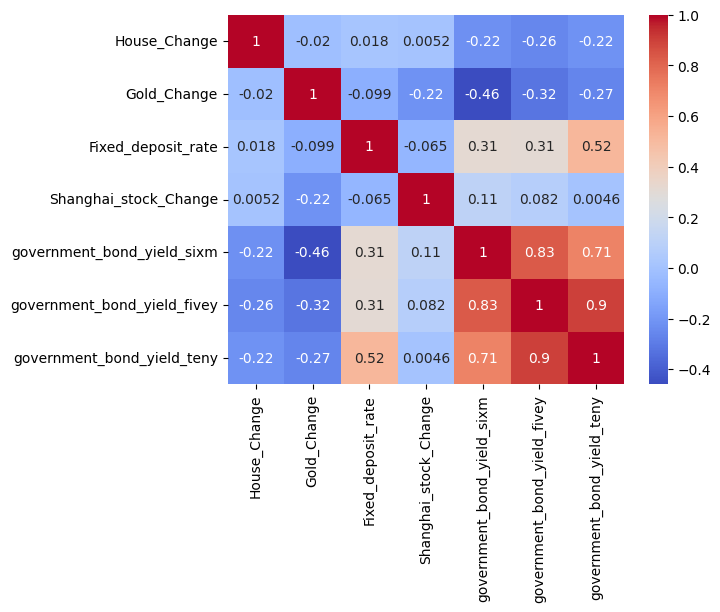

In [18]:
corr = pd.read_pickle('../data/corr.pkl')
sns.heatmap(corr, annot=True, cmap='coolwarm')

### **Summary of Regression**

In [19]:
with open('../data/summary.pkl', 'rb') as file:
    summary = pickle.load(file)
summary

<class 'statsmodels.iolib.summary2.Summary'>
"""

==================================================================================================
                             house      gold     fixed      stock      sixm     fivey       teny  
--------------------------------------------------------------------------------------------------
Fixed_deposit_rate                                                  0.1450    -0.1304*** 0.1784***
                                                                    (0.0921)  (0.0409)   (0.0381) 
Gold_Change                                               -0.3603   -0.0178** 0.0019     -0.0008  
                                                          (0.2533)  (0.0073)  (0.0038)   (0.0040) 
House_Change                                   0.0102               -0.0055   -0.0009    -0.0013  
                                               (0.0147)             (0.0087)  (0.0042)   (0.0044) 
R-squared                   0.1032   0.2514    0.4432     0.0485    0.7575    0.9093     0.8825   
R-squared Adj.              0.0113   0.1529    0.3699     0.0021    0.7182    0.8945     0.8635   
Shanghai_stock_Change                -0.1031                                                      
                                     (0.0863)                                                     
const                       10.4751  12.2054   0.6726     0.3191    -0.2136   0.0905     0.3616*  
                            (7.4499) (8.1628)  (0.7010)   (5.3414)  (0.4262)  (0.2068)   (0.2079) 
government_bond_yield_fivey -3.8398  3.5588    -1.6439***           1.2875***            0.8695***
                            (5.5431) (6.1055)  (0.5120)             (0.2648)             (0.0947) 
government_bond_yield_sixm  -0.5431  -7.1134** 0.3924                         0.3027***  -0.1307  
                            (2.7551) (3.0224)  (0.2531)                       (0.0623)   (0.0803) 
government_bond_yield_teny  0.9188   -0.8347   2.0842***            -0.5110   0.7995***           
                            (4.7937) (5.3106)  (0.4403)             (0.3141)  (0.0870)            
log_core_inflation          9.5557   0.5550    -0.2249    2.0280    0.3541    -0.0650    0.1037   
                            (7.8963) (8.6524)  (0.7384)   (15.2608) (0.4290)  (0.2097)   (0.2183) 
==================================================================================================
Standard errors in parentheses.
* p<.1, ** p<.05, ***p<.01
"""

## **Robustness Check Result**

In [20]:
def check_assumptions(model):
    # Check Linearity
    # Plotting the observed vs predicted values
    plt.scatter(model.fittedvalues, model.model.endog)
    plt.xlabel('Predicted values')
    plt.ylabel('Observed values')
    plt.title('Check for Linearity')
    plt.show()

    # Check Independence of Residuals
    # Plotting the residuals vs predicted values
    plt.scatter(model.fittedvalues, model.resid)
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title('Check for Independence of Residuals')
    plt.show()

    # Check Homoscedasticity
    # Plotting the predicted values vs residuals
    plt.scatter(model.fittedvalues, np.sqrt(np.abs(model.resid)))
    plt.xlabel('Predicted values')
    plt.ylabel('Sqrt of the Absolute Residuals')
    plt.title('Check for Homoscedasticity')
    plt.show()

    # Check Normality of Residuals
    # Histogram of the residuals
    plt.hist(model.resid, bins=30)
    plt.title('Histogram of Residuals')
    plt.show()
    
    # QQ plot
    sm.qqplot(model.resid, line='s')
    plt.title('QQ Plot')
    plt.show()

    # Check Multicollinearity
    # Calculating VIF for each variable
    X = model.model.exog
    vif_data = pd.DataFrame()
    vif_data["feature"] = model.model.exog_names
    vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
    print(vif_data)

Assumption checks for house model


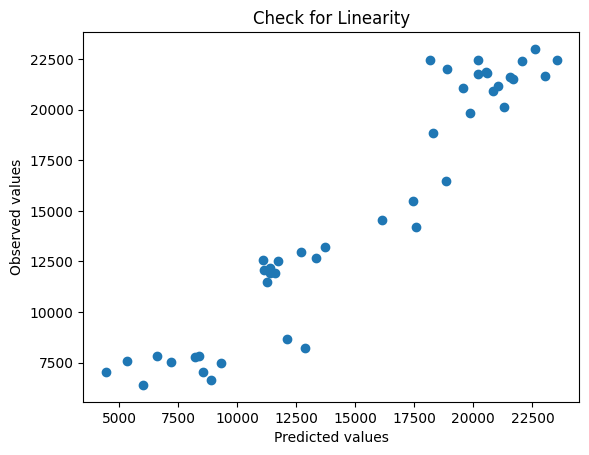

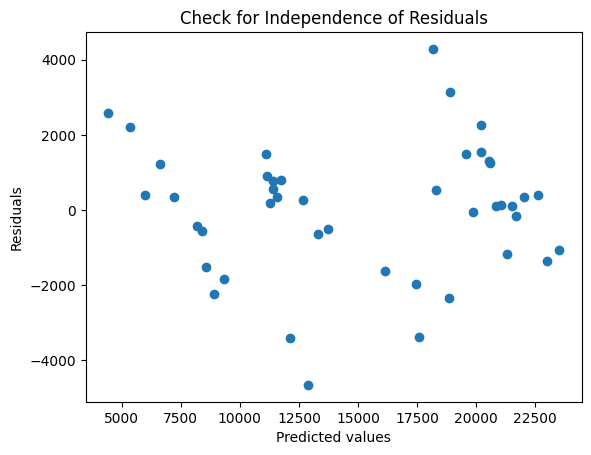

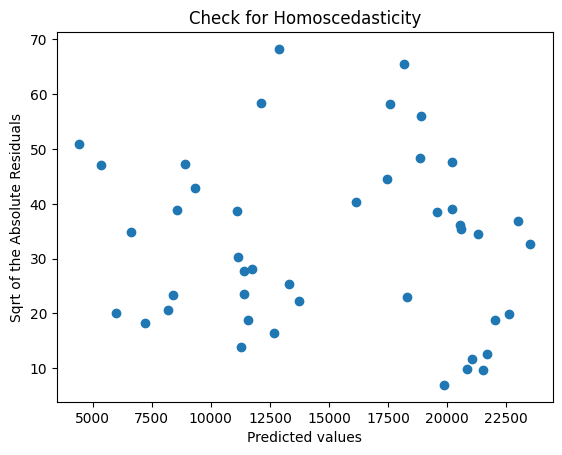

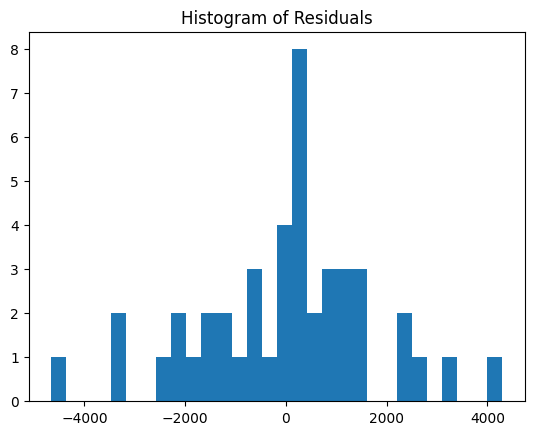

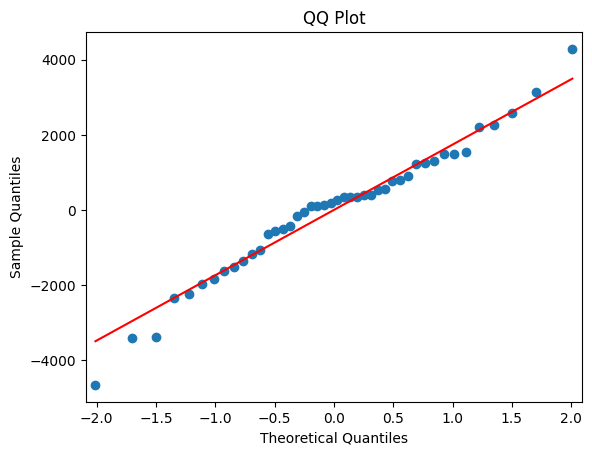

                      feature         VIF
0                   Intercept  370.694384
1    np.log1p(core_inflation)    1.257879
2                  Gold_price    1.460111
3          Fixed_deposit_rate    2.164727
4        Shanghai_stock_index    1.877528
5  government_bond_yield_sixm    2.132539
6  government_bond_yield_teny    2.792623

--------------------------------------------------

Assumption checks for gold model


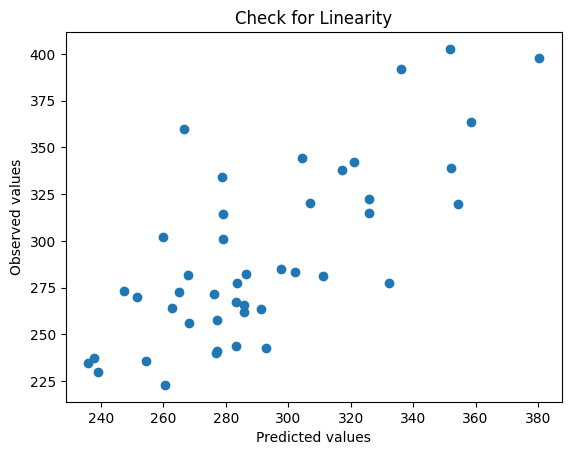

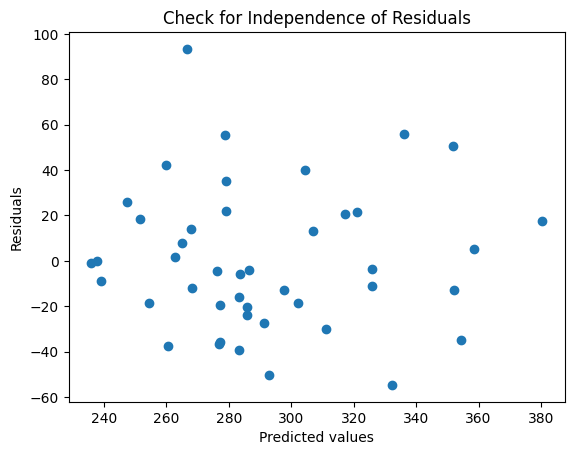

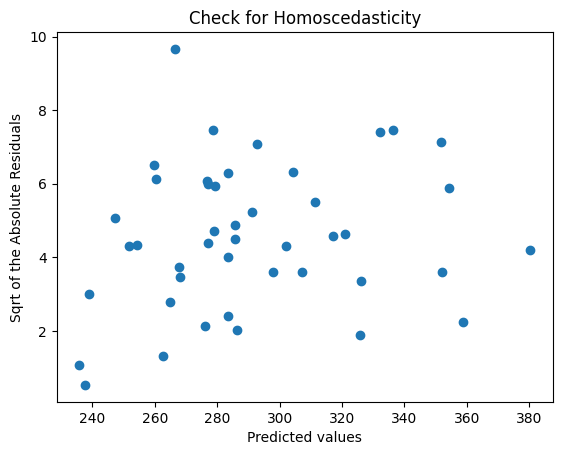

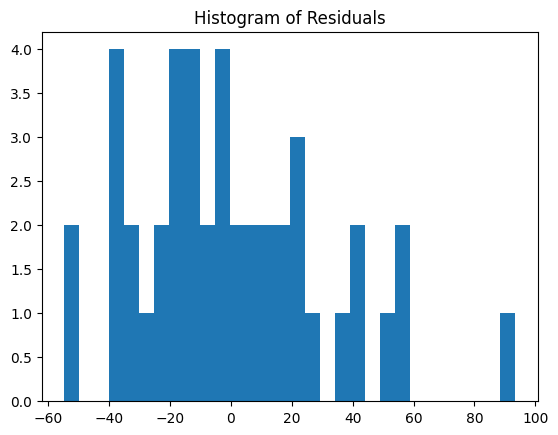

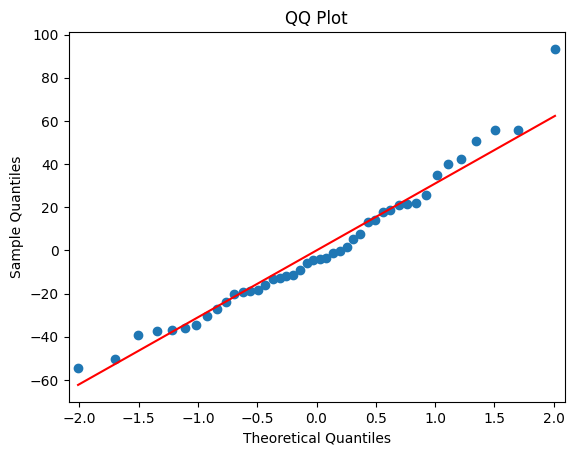

                       feature         VIF
0                    Intercept  393.793319
1     np.log1p(core_inflation)    1.117094
2                  House_price    7.294132
3           Fixed_deposit_rate    7.710695
4   government_bond_yield_sixm    3.722707
5  government_bond_yield_fivey   11.504337
6   government_bond_yield_teny    8.866874

--------------------------------------------------

Assumption checks for fixed model


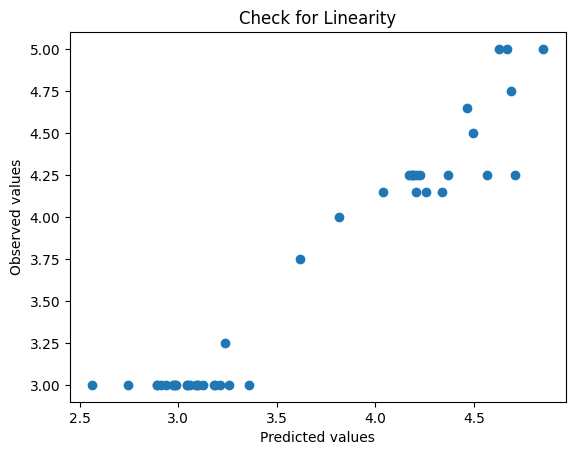

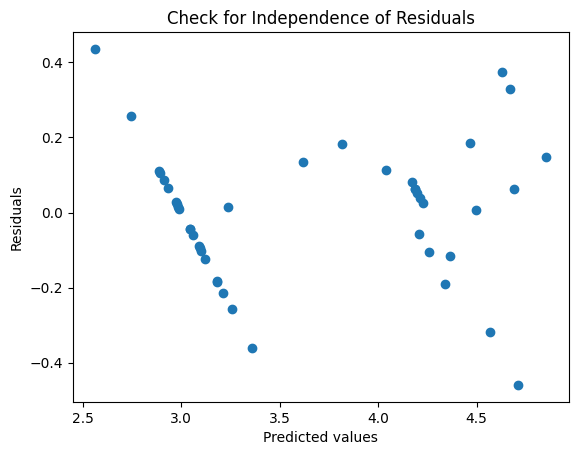

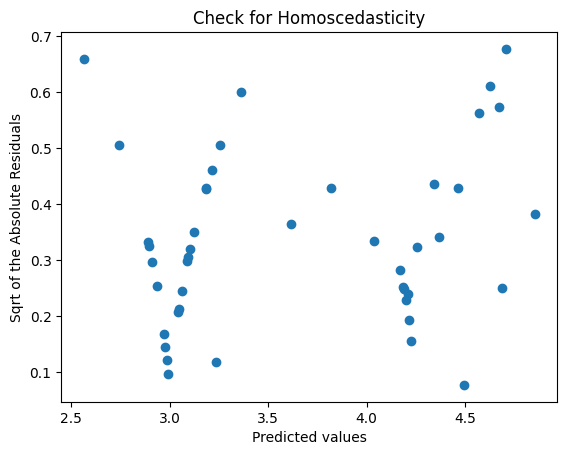

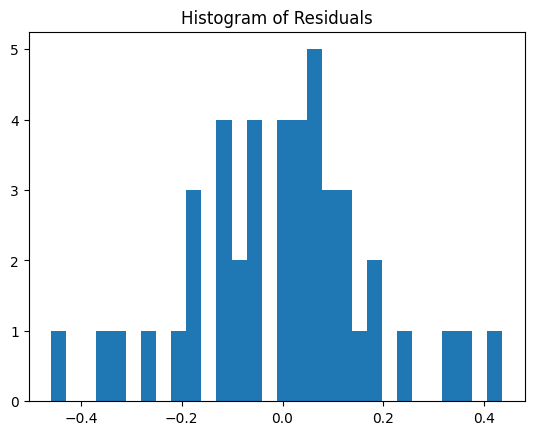

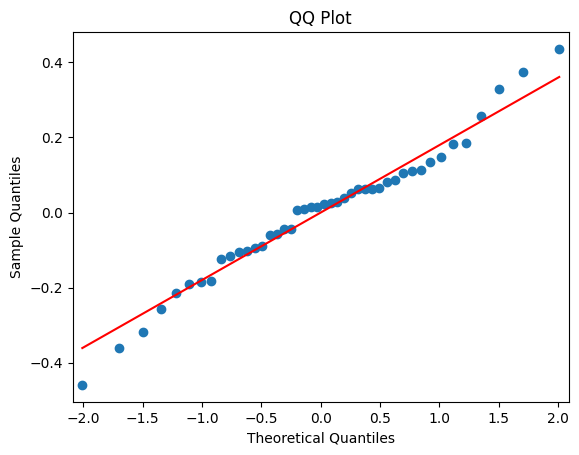

                       feature         VIF
0                    Intercept  340.517638
1     np.log1p(core_inflation)    1.253974
2                  House_price    2.031862
3                   Gold_price    1.480439
4         Shanghai_stock_index    1.642569
5   government_bond_yield_sixm    3.503838
6  government_bond_yield_fivey   11.502628
7   government_bond_yield_teny    8.859687

--------------------------------------------------

Assumption checks for stock model


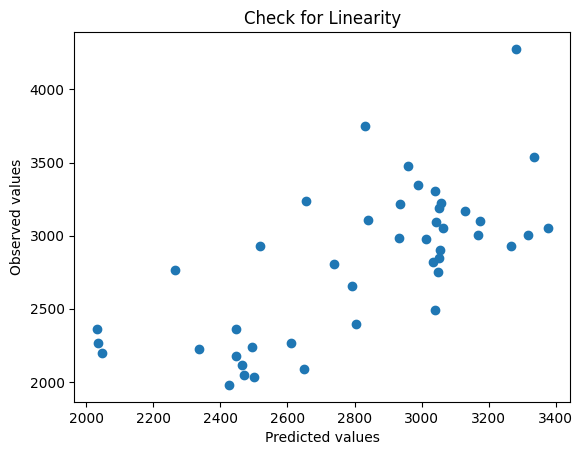

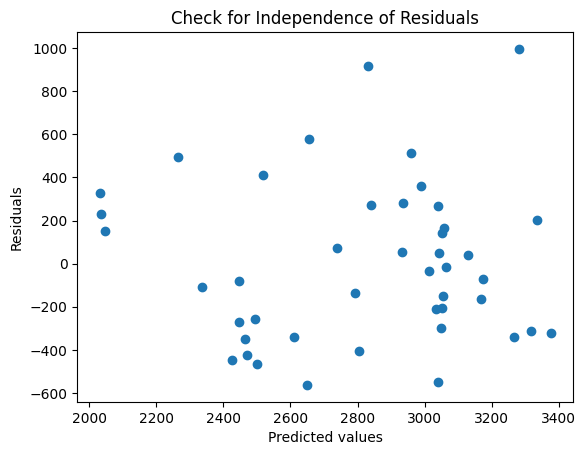

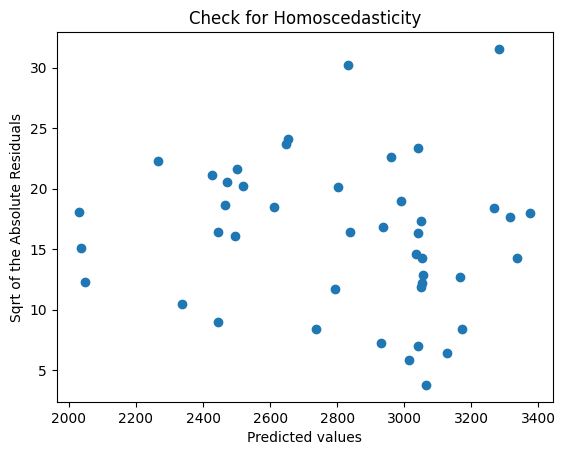

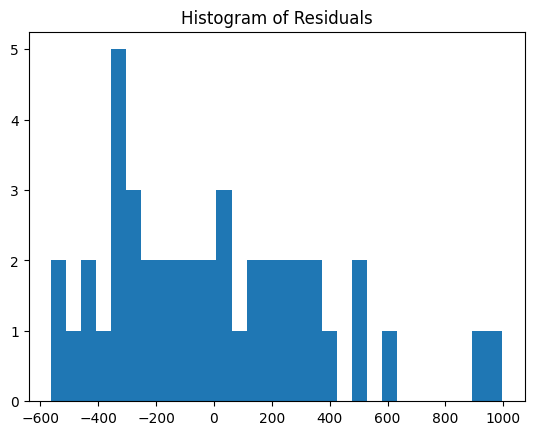

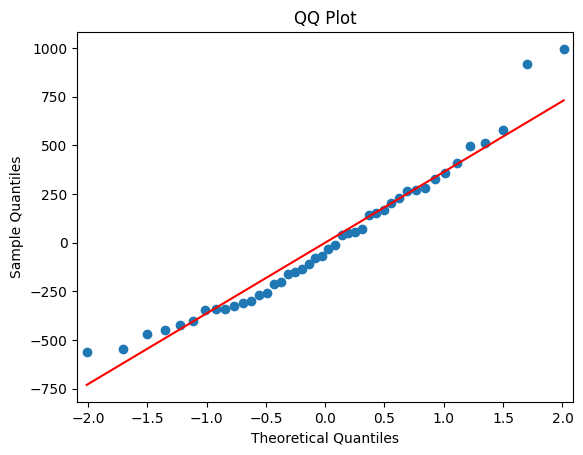

                       feature         VIF
0                    Intercept  393.793319
1     np.log1p(core_inflation)    1.117094
2                  House_price    7.294132
3           Fixed_deposit_rate    7.710695
4   government_bond_yield_sixm    3.722707
5  government_bond_yield_fivey   11.504337
6   government_bond_yield_teny    8.866874

--------------------------------------------------

Assumption checks for sixm model


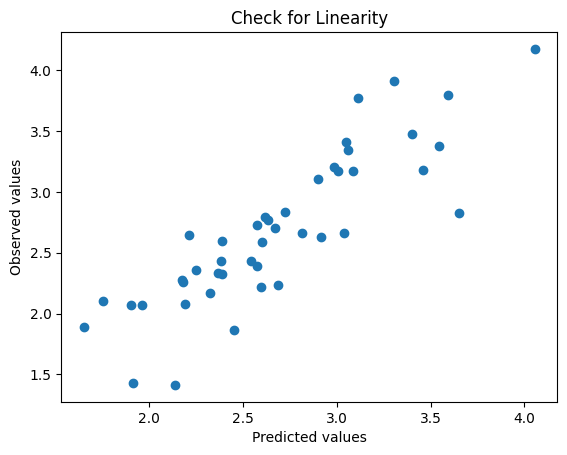

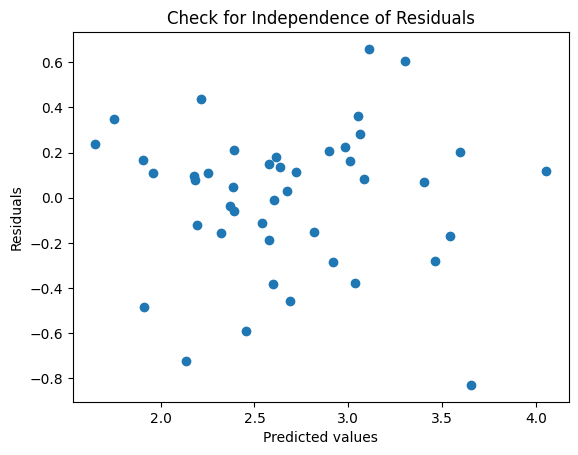

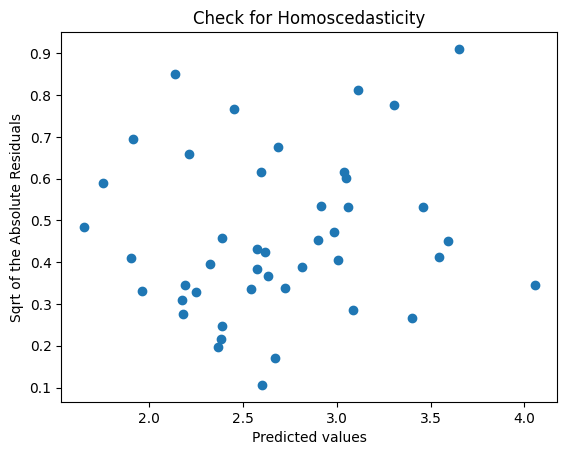

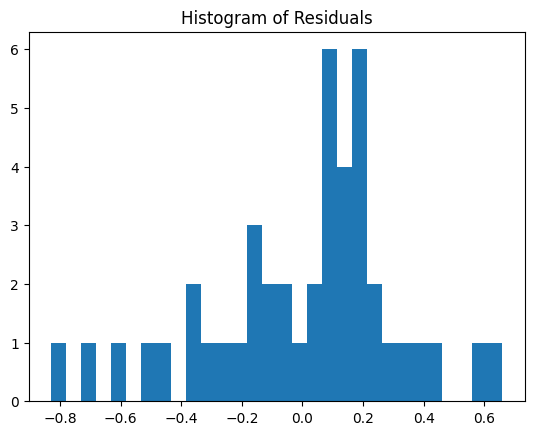

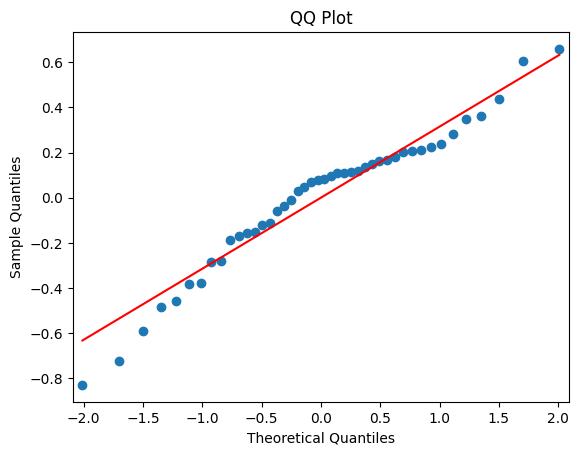

                       feature         VIF
0                    Intercept  671.123217
1     np.log1p(core_inflation)    1.248876
2                  House_price   10.908304
3                   Gold_price    2.140821
4           Fixed_deposit_rate   14.043746
5         Shanghai_stock_index    1.973311
6  government_bond_yield_fivey    8.022270
7   government_bond_yield_teny    8.710745

--------------------------------------------------

Assumption checks for fivey model


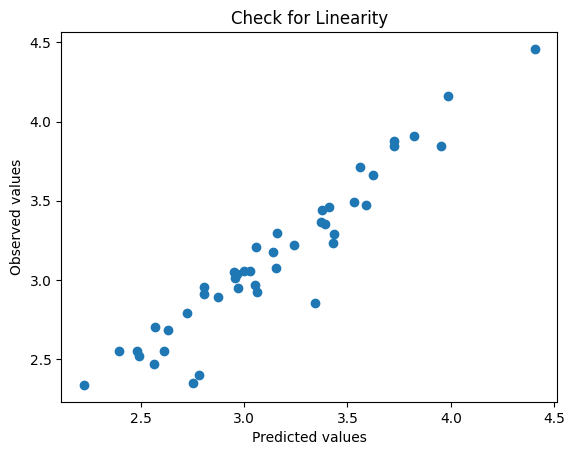

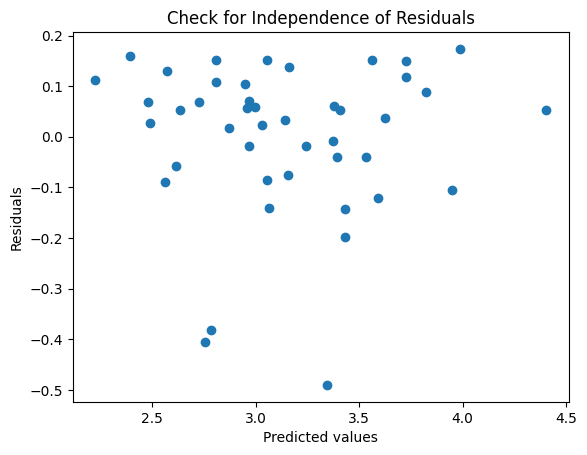

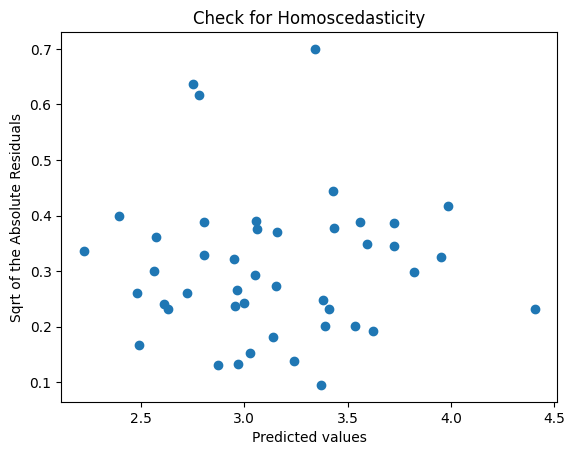

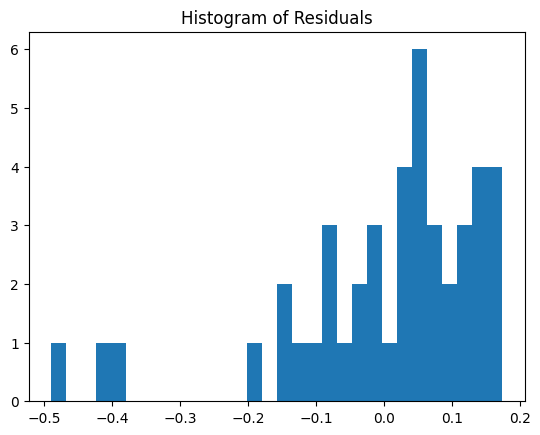

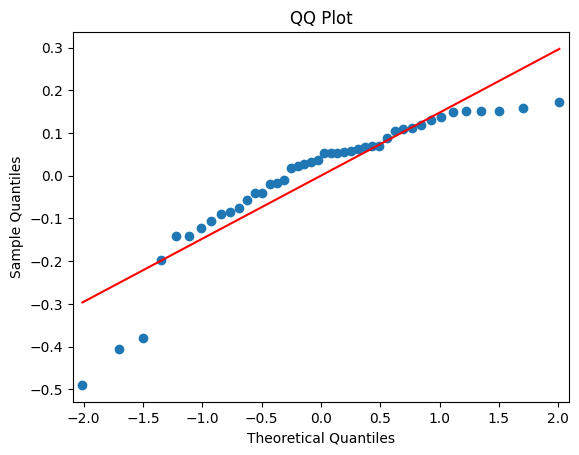

                      feature         VIF
0                   Intercept  370.694384
1    np.log1p(core_inflation)    1.257879
2                  Gold_price    1.460111
3          Fixed_deposit_rate    2.164727
4        Shanghai_stock_index    1.877528
5  government_bond_yield_sixm    2.132539
6  government_bond_yield_teny    2.792623

--------------------------------------------------

Assumption checks for teny model


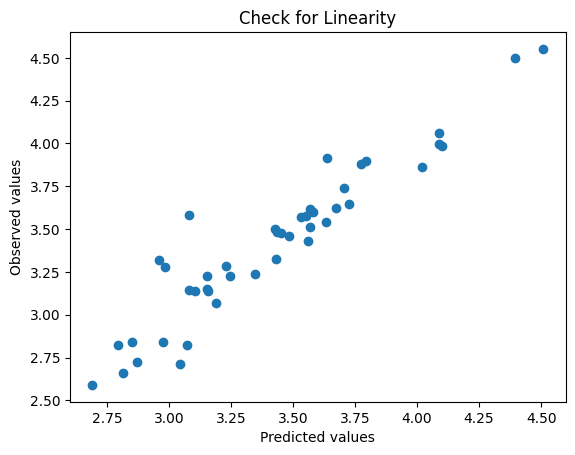

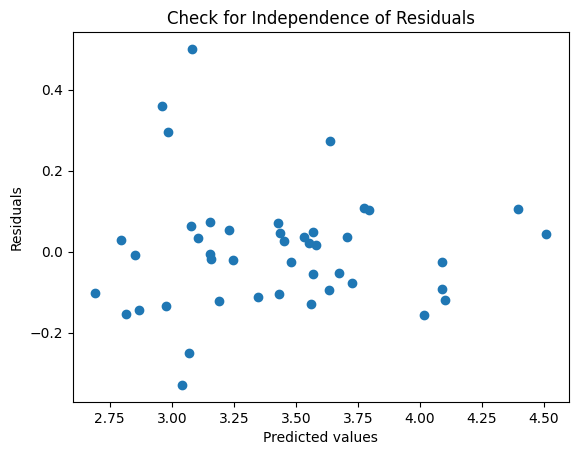

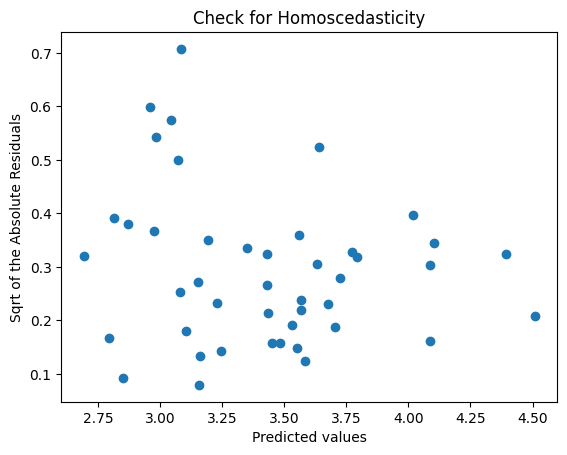

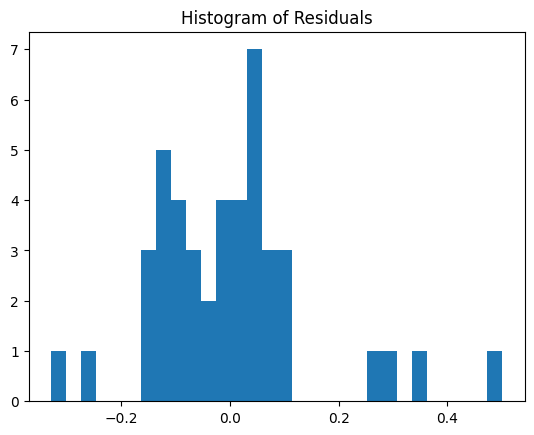

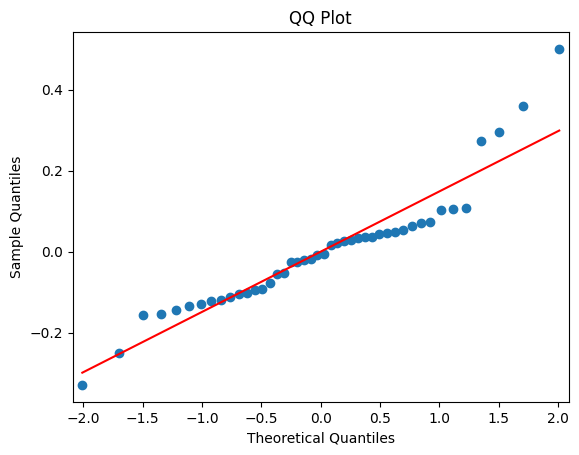

                       feature         VIF
0                    Intercept  669.980313
1     np.log1p(core_inflation)    1.254663
2                  House_price   11.863571
3                   Gold_price    2.159729
4           Fixed_deposit_rate   15.029335
5         Shanghai_stock_index    1.971737
6   government_bond_yield_sixm    3.686699
7  government_bond_yield_fivey    3.622268

--------------------------------------------------



In [21]:
with open ('../data/model.pkl', 'rb') as file:
    models = pickle.load(file)

for model_name, model in models.items():
    print(f"Assumption checks for {model_name} model")
    check_assumptions(model)
    print("\n" + "-"*50 + "\n")